In [1]:
import os
import pickle
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Load data

In [2]:
# Load .csv files

path = r'Data/Validation'
filename = ['Descriptor_global_validate.csv', 'Descriptor_atom_validate.csv', 'Descriptor_bond_validate.csv', 'Descriptor_metal_validate.csv',
            'Descriptor_linker_RDKit_validate.csv', 'Descriptor_linker_MACCS_validate.csv',
            'Descriptor_RACs_validate.csv', 'Target_validate_98.csv']

load_validate = []
for f in filename:
    if f != filename[-1]:
        load_validate.append(pd.read_csv(filepath_or_buffer=os.path.join(path,f),index_col=0).astype(float))
    else:
        load_validate.append(pd.read_csv(filepath_or_buffer=os.path.join(path,f),index_col=0))

load_validate_content = {'Global':0 , 'Atom': 1, 'Bond': 2, 'Metal': 3, 'Linker_RDKit':4, 'Linker_MACCS':5,'RACs': 6, 'Target': 7}


# Load classifier

In [3]:
def validation_dataset(select_data, select_data_content, select_descriptor, select_classifier):
    
    # (1) Build dataset for training
    
    all_index = [select_data[select_data_content[i]].index.tolist() for i in select_descriptor]
    common_index = list(set.intersection(*[set(list_) for list_ in all_index]))
    
    output_train = pd.DataFrame()
    for i in select_descriptor:
        output_train = pd.concat([output_train,select_data[select_data_content[i]].loc[common_index,:]], axis=1, ignore_index=False)
    output_train = pd.concat([output_train,select_data[-1].loc[common_index,'stability']], axis=1, ignore_index=False)
    output_train.sort_index(key=lambda x: [int(i[3:]) for i in x], inplace=True)
    
    # (2) Classification strategy
    
    file = os.path.join(r'Data/Descriptor',select_classifier+'_descriptor.csv')
    selXcols = [str(i) for i in list(pd.read_csv(file)['descriptor'])]
    
    if select_classifier == 'classifier1':
        # Classifier 1: 3 / 2, 1, 0
        output_train.loc[output_train['stability']==3,'stability']=-1
        output_train.loc[output_train['stability']==2,'stability']=1
        output_train.loc[output_train['stability']==1,'stability']=1
        output_train.loc[output_train['stability']==0,'stability']=1

    elif select_classifier == 'classifier2':
        # Classfier 2: 3, 2 / 1, 0
        output_train.loc[output_train['stability']==3,'stability']=-1
        output_train.loc[output_train['stability']==2,'stability']=-1
        output_train.loc[output_train['stability']==1,'stability']=1
        output_train.loc[output_train['stability']==0,'stability']=1
    
    output_X = output_train.iloc[:,:-1]
    output_Y = output_train.iloc[:,-1]
    output_X = output_X[selXcols].copy()
    output_X.sort_index(axis=1,inplace=True)
    output_train = output_train[selXcols]

    # (3) Classifier
    output_CLF = pickle.load( open(os.path.join(r'Model',select_classifier+'.pkl'),
                                   "rb" ) )
    output_scaler = pickle.load( open(os.path.join(r'Model',select_classifier+'_scaler.pkl'),
                                   "rb" ) )
    
    print(select_classifier, ':')
    print('Stable MOF: ', Counter(output_Y)[-1], ', Unstable MOF: ', Counter(output_Y)[1])
    print('Feature space dimension:', output_X.shape)
    return output_train, output_X, output_Y, output_CLF, output_scaler
    

# Validation: classifier Ⅰ

In [4]:
select_descriptor = ['Global','Metal','Linker_MACCS','Linker_RDKit']
validate_all, validate_X, validate_Y, CLF, CLF_scaler = validation_dataset(select_data = load_validate,
                                                                           select_data_content = load_validate_content, 
                                                                           select_descriptor=select_descriptor,
                                                                           select_classifier='classifier1')

classifier1 :
Stable MOF:  92 , Unstable MOF:  6
Feature space dimension: (98, 75)


In [5]:
# Validate classifier

validate_x = CLF_scaler.transform(validate_X.values)
prediction = CLF.predict(validate_x)
prob       = CLF.predict_proba(validate_x)

prediction = pd.DataFrame(prediction, columns=['prediction'])
prediction['prob_class-1'] = prob[:,0]
prediction['prob_class1'] = prob[:,1]
prediction['true_class'] = validate_Y.values
prediction.index = validate_X.index

print('ACC:',round(accuracy(y_true=validate_Y,y_pred=prediction['prediction']),2))
print('Precision:',round(precision_score(y_true=validate_Y, y_pred=prediction['prediction'], pos_label=-1),2))
print('Recall:',round(recall_score(y_true=validate_Y, y_pred=prediction['prediction'], pos_label=-1),2))
print('F1:',round(f1_score(y_true=validate_Y, y_pred=prediction['prediction'], pos_label=-1),2))
print('AUC:',round(roc_auc_score(validate_Y, prediction['prediction']),2))
print()
correct = prediction.loc[prediction['prediction']==prediction['true_class']]
error = prediction.loc[prediction['prediction']!=prediction['true_class']]
print('Correct results:', correct.shape[0])
print('Wrong results:', error.shape[0])


ACC: 0.98
Precision: 1.0
Recall: 0.98
F1: 0.99
AUC: 0.99

Correct results: 96
Wrong results: 2


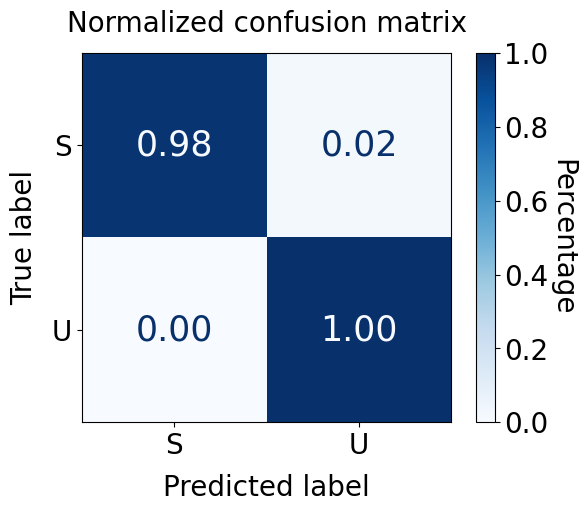

In [6]:
text_kw = {'fontsize':25}
class_names = ['S','U']
titles_options = [("Normalized confusion matrix", "Percentage","true", 1, '.2f')]

for title, label, normalize, c, format in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
            CLF,
            validate_x,
            validate_Y,
            display_labels=class_names,
            cmap=plt.cm.Blues,
            normalize=normalize,
            text_kw = text_kw,
            values_format = format)
    disp.ax_.set_title(title, fontsize=20, pad=15)
    disp.ax_.tick_params(labelsize=20)
    disp.ax_.set_ylabel('True label',fontsize=20, labelpad=10)
    disp.ax_.set_xlabel('Predicted label',fontsize=20, labelpad=10)
    disp.im_.set_clim(0, c)
    cbar = disp.im_.colorbar
    cbar.ax.tick_params(labelsize=20)
    cbar.set_label(label, rotation=-90, fontsize=20, labelpad=20)
plt.show()

# Validation: classifier Ⅱ

In [7]:
select_descriptor = ['Global','Metal','Linker_MACCS','Linker_RDKit']
validate_all, validate_X, validate_Y, CLF, CLF_scaler = validation_dataset(select_data = load_validate,
                                                                           select_data_content = load_validate_content, 
                                                                           select_descriptor=select_descriptor,
                                                                           select_classifier='classifier2')

classifier2 :
Stable MOF:  96 , Unstable MOF:  2
Feature space dimension: (98, 60)


In [8]:
# Validate classifier

validate_x = CLF_scaler.transform(validate_X.values)
prediction = CLF.predict(validate_x)
prob       = CLF.predict_proba(validate_x)

prediction = pd.DataFrame(prediction, columns=['prediction'])
prediction['prob_class-1'] = prob[:,0]
prediction['prob_class1'] = prob[:,1]
prediction['true_class'] = validate_Y.values
prediction.index = validate_X.index

print('ACC:',round(accuracy(y_true=validate_Y,y_pred=prediction['prediction']),2))
print('Precision:',round(precision_score(y_true=validate_Y, y_pred=prediction['prediction'], pos_label=-1),2))
print('Recall:',round(recall_score(y_true=validate_Y, y_pred=prediction['prediction'], pos_label=-1),2))
print('F1:',round(f1_score(y_true=validate_Y, y_pred=prediction['prediction'], pos_label=-1),2))
print('AUC:',round(roc_auc_score(validate_Y, prediction['prediction']),2))
print()
correct = prediction.loc[prediction['prediction']==prediction['true_class']]
error = prediction.loc[prediction['prediction']!=prediction['true_class']]
print('Correct results:', correct.shape[0])
print('Wrong results:', error.shape[0])


ACC: 0.99
Precision: 0.99
Recall: 1.0
F1: 0.99
AUC: 0.75

Correct results: 97
Wrong results: 1


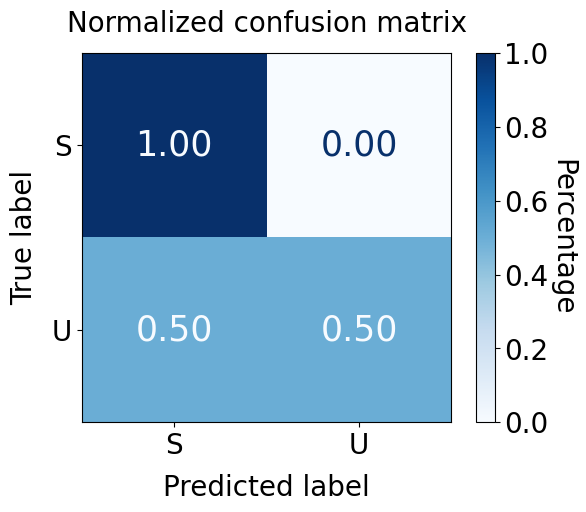

In [9]:
text_kw = {'fontsize':25}
class_names = ['S','U']
titles_options = [("Normalized confusion matrix", "Percentage","true", 1, '.2f')]

for title, label, normalize, c, format in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
            CLF,
            validate_x,
            validate_Y,
            display_labels=class_names,
            cmap=plt.cm.Blues,
            normalize=normalize,
            text_kw = text_kw,
            values_format = format)
    disp.ax_.set_title(title, fontsize=20, pad=15)
    disp.ax_.tick_params(labelsize=20)
    disp.ax_.set_ylabel('True label',fontsize=20, labelpad=10)
    disp.ax_.set_xlabel('Predicted label',fontsize=20, labelpad=10)
    disp.im_.set_clim(0, c)
    cbar = disp.im_.colorbar
    cbar.ax.tick_params(labelsize=20)
    cbar.set_label(label, rotation=-90, fontsize=20, labelpad=20)
plt.show()